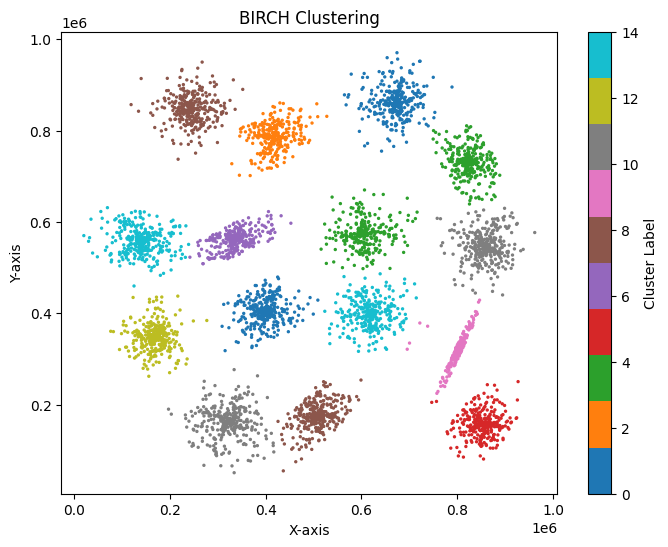

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class BIRCH:
    #Default Constructor
    def __init__(self, threshold, branching_factor, n_clusters):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.leaf_or_not = True
        self.children = []
        self.CFs_ = []  

    # Add a new point to the tree
    def insert(self, point):
        
        match self.leaf_or_not:
            case True:  # If it's a leaf node
                nearest_CF = None
                minimum_distance = float('inf')

                # Find the closest CF (cluster feature)
                for cf in self.CFs_:
                    centroid = cf['LS'] / cf['N']  # Get centroid by dividing LS by N
                    difference = centroid - point  # Find the difference between point and centroid
                    squared_difference = difference ** 2  # Square the difference
                    sum_of_squares = np.sum(squared_difference)  # Add up the squares
                    dist = np.sqrt(sum_of_squares)  # Calculate Euclidean distance

                    if dist < minimum_distance:
                        nearest_CF = cf
                        minimum_distance = dist

                # Update the closest CF or create a new CF
                match nearest_CF is not None and minimum_distance <= self.threshold:
                    case True:  # Update the closest CF
                        nearest_CF['N'] = nearest_CF['N'] + 1
                        nearest_CF['LS'] = nearest_CF['LS'] + point
                        nearest_CF['SS'] = nearest_CF['SS'] + (point ** 2)
                    case False:  # Create a new CF
                        new_CF = {}
                        new_CF['N'] = 1  # Set the number of points to 1
                        new_CF['LS'] = point  # Set LS to the point
                        new_CF['SS'] = point ** 2  # Set SS to the square of the point
                        self.CFs_.append(new_CF)

                # Split the node if it exceeds the branching factor
                if len(self.CFs_) > self.branching_factor:
                    self.split()

            case False:  # If it's not a leaf node
                closest_child = None
                minimum_distance = float('inf')

                # Find the closest child node
                for child in self.children:
                    if child.CFs_:  # Check if child has CFs_
                        cf = child.CFs_[0]

                        centroid = cf['LS'] / cf['N']  # Get centroid of the CF
                        difference = centroid - point  # Find the difference between centroid and point
                        squared_difference = difference ** 2  # Square the difference
                        sum_of_squares = np.sum(squared_difference)  # Add up the squared differences
                        dist = np.sqrt(sum_of_squares)  # Calculate the Euclidean distance

                        if dist < minimum_distance:
                            closest_child = child
                            minimum_distance = dist

                # Pass the point to the closest child
                if closest_child:
                    closest_child.insert(point)


    def split(self):
        
        # Sort the CFs_ by the distance of their centroids
        cf_with_distances = []

        for cf in self.CFs_:
            centroid = cf['LS'] / cf['N']  # Calculate the centroid
            difference = centroid  # Difference from origin
            squared_difference = difference ** 2  # Square the difference
            sum_of_squares = np.sum(squared_difference)  # Add up the squares
            distance = np.sqrt(sum_of_squares)  # Calculate the distance

            cf_with_distances.append((distance, cf))

        # Sort the CFs_ by their distance from the origin
        cf_with_distances.sort(key=lambda x: x[0])

        # Separate the sorted CFs_ into two groups
        sorted_CFs_ = [cf for _, cf in cf_with_distances]
        
        midpoint = len(sorted_CFs_) // 2

        left_child = BIRCH(self.threshold, self.branching_factor, self.n_clusters)
        right_child = BIRCH(self.threshold, self.branching_factor, self.n_clusters)
        left_child.CFs_ = sorted_CFs_[:midpoint]
        right_child.CFs_ = sorted_CFs_[midpoint:]

        self.children = [left_child, right_child]
        self.leaf_or_not = False
        self.CFs_ = []  
        
    #getter for leaf nodes
    def get_leaf_nodes(self):
        if self.leaf_or_not:
            return [self]
        leaf_nodes = []
        for child in self.children:
            leaf_nodes.extend(child.get_leaf_nodes())
        return leaf_nodes

    #k-means
    def kmeans(self, X, k, max_iter=100):
        random_ = np.random.choice(X.shape[0], k, replace=False)
        centers = X[random_]

        labels = np.zeros(X.shape[0], dtype=int)

        iteration = 0
        while iteration < max_iter:
            distances = np.zeros((X.shape[0], k))

            # Calculating the distace from each point to centroid each point
            point_index = 0
            while point_index < X.shape[0]:
                centroid_index = 0
                while centroid_index < k:
                    diff = X[point_index] - centers[centroid_index]  # Find the difference
                    squared_diff = diff ** 2  # Square the difference
                    sum_of_squares = np.sum(squared_diff)  # Sum the squares
                    distances[point_index, centroid_index] = np.sqrt(sum_of_squares)  # Euclidean distance
                    centroid_index = centroid_index + 1
                point_index = point_index + 1

            new_labels = np.argmin(distances, axis=1)

            if np.all(labels == new_labels):
                break
            
            labels = new_labels

            # Updating centroids according to new labels
            centroid_index = 0
            while centroid_index < k:
                points_in_cluster = X[labels == centroid_index]
                if len(points_in_cluster) > 0:
                    centers[centroid_index] = np.mean(points_in_cluster, axis=0)
                centroid_index = centroid_index + 1

            iteration = iteration + 1

        return centers, labels

    #Buildin CF Tree and perform clustering
    def apply_model(self, X):
        for point in X:
            self.insert(point)

        # Extract CFs_ from leaf nodes
        leaf_nodes = self.get_leaf_nodes()
        cf_list = []
        for node in leaf_nodes:
            for cf in node.CFs_:
                cf_list.append(cf)
        
        cf_centers = []
        for cf in cf_list:
            center = cf['LS'] / cf['N']
            cf_centers.append(center)
        
        cf_centers = np.array(cf_centers)

        # Perform k-means on CFs_
        final_centers, labels = self.kmeans(X, self.n_clusters)
        return final_centers, labels

# Hyperparameters
threshold = 1.0
branching_factor = 50
n_clusters = 15

# Load dataset
data_file = 's1.txt'  # S-Set ->  s1.txt file
X = np.loadtxt(data_file)   # Load the dataset

# Call BIRCH clustering
birch = BIRCH(threshold, branching_factor, n_clusters)
final_centers, labels = birch.apply_model(X)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar(scatter, label="Cluster Label")
plt.title("BIRCH Clustering")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()


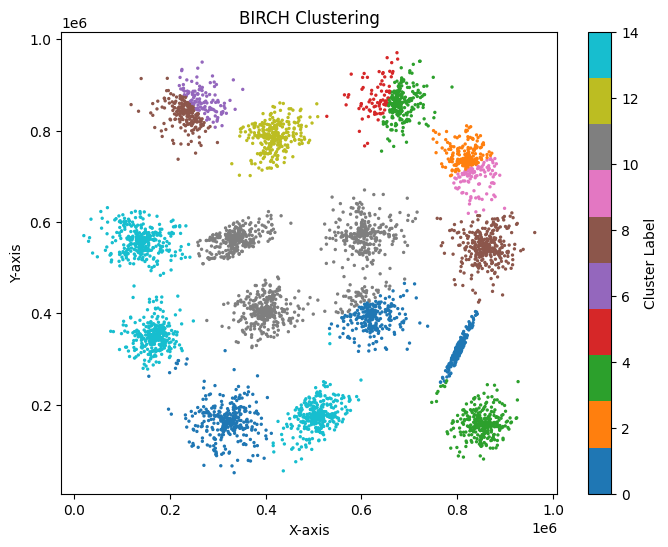

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

class BIRCH:
    # Default Constructor
    def __init__(self, threshold, branching_factor, n_clusters):
        self.threshold = threshold
        self.branching_factor = branching_factor
        self.n_clusters = n_clusters
        self.leaf_or_not = True
        self.children = []
        self.CFs_ = []

    # Insert function with Manhattan distance
    def insert(self, point):
        match self.leaf_or_not:
            case True:  # If it's a leaf node
                nearest_CF = None
                minimum_distance = float('inf')

                # Find the closest CF 
                for cf in self.CFs_:
                    centroid = cf['LS'] / cf['N'] # Get centroid by dividing LS by N
                    difference = np.abs(centroid - point)  # Absolute difference for Manhattan distance
                    dist = np.sum(difference)  # Manhattan distance (sum of absolute differences)

                    if dist < minimum_distance:
                        nearest_CF = cf
                        minimum_distance = dist

                # Update the closest CF or create a new CF
                if nearest_CF is not None and minimum_distance <= self.threshold:
                    nearest_CF['N'] += 1
                    nearest_CF['LS'] += point
                    nearest_CF['SS'] += (point ** 2)
                else:
                    new_CF = {'N': 1, 'LS': point, 'SS': point ** 2}
                    self.CFs_.append(new_CF)

                if len(self.CFs_) > self.branching_factor:
                    self.split()

            case False:  # If it's not a leaf node
                closest_child = None
                minimum_distance = float('inf')

                # Find the closest child node
                for child in self.children:
                    if child.CFs_:
                        cf = child.CFs_[0]
                        centroid = cf['LS'] / cf['N']
                        difference = np.abs(centroid - point)  # Absolute difference for Manhattan distance
                        dist = np.sum(difference)  # Manhattan distance

                        if dist < minimum_distance:
                            closest_child = child
                            minimum_distance = dist

                if closest_child:
                    closest_child.insert(point)

    def split(self):
        """Split the node if it has too many CFs_."""

        # Sort the CFs_ by the distance of their centroids
        cf_with_distances = []

        for cf in self.CFs_:
            centroid = cf['LS'] / cf['N']  # Calculate the centroid
            difference = centroid  # Difference from origin
            squared_difference = difference ** 2  # Square the difference
            sum_of_squares = np.sum(squared_difference)  # Add up the squares
            distance = np.sqrt(sum_of_squares)  # Calculate the distance

            cf_with_distances.append((distance, cf))

        # Sort the CFs_ by their distance from the origin
        cf_with_distances.sort(key=lambda x: x[0])

        # Separate the sorted CFs_ into two groups
        sorted_CFs_ = [cf for _, cf in cf_with_distances]

        midpoint = len(sorted_CFs_) // 2

        left_child = BIRCH(self.threshold, self.branching_factor, self.n_clusters)
        right_child = BIRCH(self.threshold, self.branching_factor, self.n_clusters)
        left_child.CFs_ = sorted_CFs_[:midpoint]
        right_child.CFs_ = sorted_CFs_[midpoint:]

        self.children = [left_child, right_child]
        self.leaf_or_not = False
        self.CFs_ = []

    # Getter for leaf nodes
    def get_leaf_nodes(self):
        if self.leaf_or_not:
            return [self]
        leaf_nodes = []
        for child in self.children:
            leaf_nodes.extend(child.get_leaf_nodes())
        return leaf_nodes

    # K-means function
    def kmeans(self, X, k, max_iter=100):
        random_ = np.random.choice(X.shape[0], k, replace=False)
        centers = X[random_]

        labels = np.zeros(X.shape[0], dtype=int)

        iteration = 0
        while iteration < max_iter:
            distances = np.zeros((X.shape[0], k))

            # Calculating the distance from each point to centroid each point
            point_index = 0
            while point_index < X.shape[0]:
                centroid_index = 0
                while centroid_index < k:
                    diff = X[point_index] - centers[centroid_index]  # Find the difference
                    squared_diff = diff ** 2  # Square the difference
                    sum_of_squares = np.sum(squared_diff)  # Sum the squares
                    distances[point_index, centroid_index] = np.sqrt(sum_of_squares)  # Euclidean distance
                    centroid_index = centroid_index + 1
                point_index = point_index + 1

            new_labels = np.argmin(distances, axis=1)

            if np.all(labels == new_labels):
                break

            labels = new_labels

            # Updating centroids according to new labels
            centroid_index = 0
            while centroid_index < k:
                points_in_cluster = X[labels == centroid_index]
                if len(points_in_cluster) > 0:
                    centers[centroid_index] = np.mean(points_in_cluster, axis=0)
                centroid_index = centroid_index + 1

            iteration = iteration + 1

        return centers, labels

    # Build CF Tree and perform clustering
    def apply_model(self, X):
        for point in X:
            self.insert(point)

        # Extract CFs_ from leaf nodes
        leaf_nodes = self.get_leaf_nodes()
        cf_list = []
        for node in leaf_nodes:
            for cf in node.CFs_:
                cf_list.append(cf)

        cf_centers = []
        for cf in cf_list:
            center = cf['LS'] / cf['N']
            cf_centers.append(center)

        cf_centers = np.array(cf_centers)

        # Perform k-means on CFs_
        final_centers, labels = self.kmeans(X, self.n_clusters)
        return final_centers, labels


# Hyperparameters
threshold = 0.2
branching_factor = 50
n_clusters = 15

# Load dataset
data_file = 's1.txt'  # S-Set ->  s1.txt file
X = np.loadtxt(data_file)   # Load the dataset

# Call BIRCH clustering
birch = BIRCH(threshold, branching_factor, n_clusters)
final_centers, labels = birch.apply_model(X)

# Plotting
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='tab10', s=2)
plt.colorbar(scatter, label="Cluster Label")
plt.title("BIRCH Clustering")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()
